<h1><span style= "color: #c7c9cf">The5Outliers - </span><span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span><span style= "color: #c7c9cf">: why so many players pass through Geography or Countries to reach their target</span></h1>

In [285]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
import seaborn as sn
import matplotlib.pyplot as plt

from src.data_loader import *
from src.helpers import *
from src.models.networks import *
from src.htmlParser import htmlParser

parser = htmlParser()
parser.load_pickle()

# 1. Data cleaning and loading

This part loads, cleans the data, and defines useful datasets for further analysis. 

- `read_articles()` loads a list of valid article names, that is without special characters and discardig any invalid articles, like non-wikispedia articles or with missing categories
- `parser.get_df_html_stats()` gathers wikispedia page statistics like number of links, link density, and structural information
- `read_categories()` sorts for each category of a same article its different levels of sub categories 
- `read_links()` gathers all the links outward of a page 
- `read_shortest_path_matrix()` reads the matrix of shortest paths possible between two articles 
- `read_unfinished_paths()` and `read_finished_paths()` load the original unfinished and finished paths and clean them
- `read_similartiy_matrix()` reads the matrix of semantic similarity between article names 
- `read_categories_matrix()` reads the matrix that describes the similarity between article's category levels and sub-levels

In [287]:
df_article_names = read_articles() 
df_html_stats = parser.get_df_html_stats()
df_categories = read_categories()
df_links = read_links()
df_shortest_path = read_shortest_path_matrix()
df_unfinished = read_unfinished_paths()
df_finished = read_finished_paths() 
df_sm = read_similartiy_matrix() 
df_scat = read_categories_matrix()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Podcast', 'Kashmir', 'Test', 'Sportacus', 'English', 'Rss', 'Black ops 2', 'Western Australia', 'Macedonia', 'Georgia', 'Fats', 'Rat', 'Bogota', 'Great', 'The Rock', 'Mustard', 'Adolph Hitler', 'Netbook', 'The', 'Usa', ' Zebra', 'Charlottes web', 'Pikachu', 'Long peper', 'Christmas'}
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24714 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of rows after filtering: 51199


- Numbers of articles != Numbers of articles with a least one **link** directing to it
- May be more links per Article, if the same link repeat again througth the artcile, need to confirm by looking at the text or HTML
- Numbers of articles != Numbers of articles with a least one **link** to another article in the corpus

To explore more basic stufs...

# 2. Add features to articles and paths

## 2.1. Article features 
In and out degree of articles are added. 
- **In degree** of an article corresponds to the number of links on other page targetting this article 
- **Out degree** of an article corresponds to the number of links towards other pages on this article

In [288]:
# TODO: Add more atributes to the articles itself with parsing and more!!!
# TODO: Logic we have differents approaches (the paths connections withins articles, the articles it self, the categories...)

df_article = pd.DataFrame(df_article_names).copy()

# Compute in-degree (number of times each article is a target link)
in_degree = df_links.groupby('linkTarget').size().reset_index(name="in_degree")
# Compute out-degree (link density: number of times each article is a source link)
out_degree = df_links.groupby('linkSource').size().reset_index(name="out_degree")

# Merge in-degree and out-degree with df_article_names
df_article = df_article.merge(in_degree, left_on='article', right_on='linkTarget', how='left')
df_article = df_article.merge(out_degree, left_on='article', right_on='linkSource', how='left')
df_article = df_article.drop(columns=['linkTarget', 'linkSource'])

# Fill NaN values with 0, assuming no links imply zero counts for those articles
df_article = df_article.fillna(0).astype({'in_degree': 'int', 'out_degree': 'int'})

df_article


,article,in_degree,out_degree
0,Áedán mac Gabráin,0,11
1,Åland,0,19
2,Édouard Manet,0,20
3,Éire,0,8
4,Óengus I of the Picts,0,10
...,...,...,...
4592,Zionism,25,74
4593,Zirconium,15,42
4594,Zoroaster,9,28
4595,Zuid-Gelders,5,5


## 2.2. Path features 
New metrics are added to characterize the game paths. Specifically:

- **Path Length** which accounts for the total number of articles in a path

- **Back Clicks** which indicates how many times the user revisited previous articles

- **Cosine Similarity** which measures the semantic similarity between the source and target articles

- **Shortest Path** which gives the length of the shortest path possible between the source and target articles

- **Categories Similarity** which  measure the category similarity between the categories of the source and target articles

In [289]:
# let's add some useful metrics to each paths dataframe: shortest path, semantic similarity
df_unfinished['cosine_similarity'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_unfinished['shortest_path'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_unfinished['path_length'] = df_unfinished['path'].apply(lambda x: x.count(';') + 1)
df_unfinished['back_clicks'] = df_unfinished['path'].apply(lambda x: x.count('<'))
df_unfinished['categories_similarity'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

df_finished['cosine_similarity'] = df_finished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_finished['shortest_path'] = df_finished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_finished['path_length'] = df_finished['path'].apply(lambda x: x.count(';') + 1)
df_finished['back_clicks'] = df_finished['path'].apply(lambda x: x.count('<'))
df_finished['categories_similarity'] = df_finished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

# 3. Core results

## 3.1. Article features

### 3.1.a. Distributions of words, links, and categories in articles

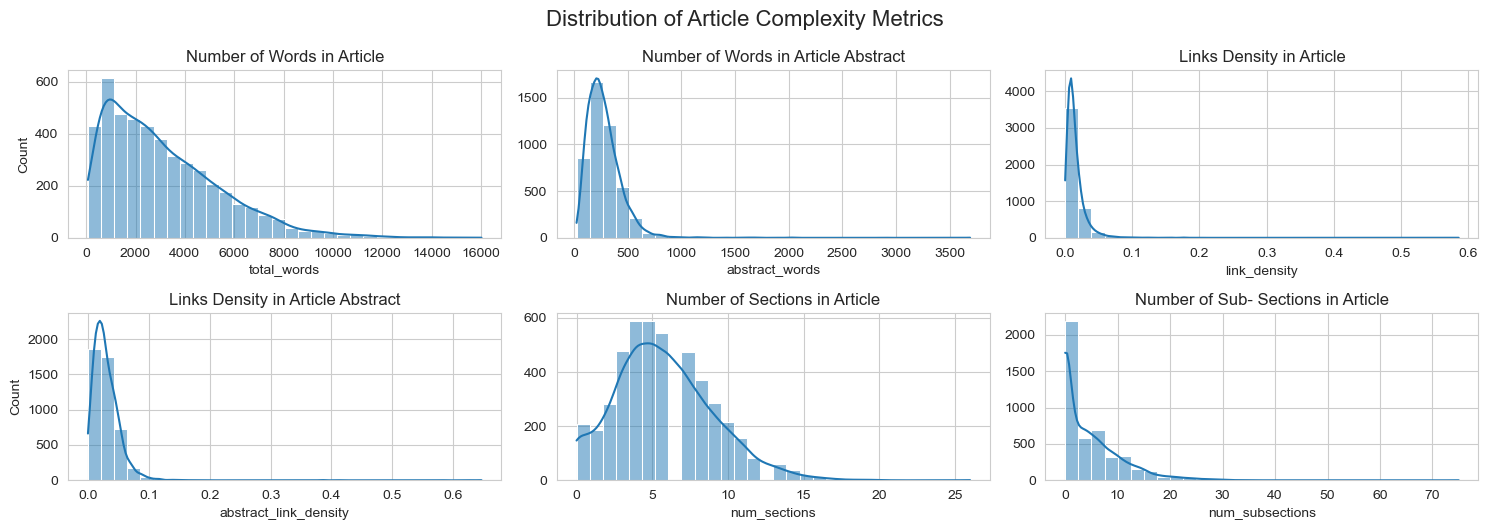

In [290]:
category_map = dict(zip(df_categories["article"], df_categories["level_1"]))
df_html_stats["category"] = df_html_stats["article_name"].map(category_map)

metrics = [
    ("total_words", "Number of Words in Article"),
    ("abstract_words", "Number of Words in Article Abstract"),
    ("link_density", "Links Density in Article"),
    ("abstract_link_density", "Links Density in Article Abstract"),
    ("num_sections", "Number of Sections in Article"),
    ("num_subsections", "Number of Sub- Sections in Article")
]

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Loop through metrics to create histograms
for i, (metric, title) in enumerate(metrics):
    row, col = divmod(i, 3)
    sn.histplot(df_html_stats, x=metric, bins=30, kde=True, ax=ax[row, col])
    ax[row, col].set_title(title)
    if col == 1 or col == 2:
        ax[row, col].set_ylabel('')

plt.tight_layout()
plt.suptitle("Distribution of Article Metrics", y=1.05, fontsize=16)
plt.show()

Results : The data is right-skewed for most of metrics, indicating that while most articles adhere to certain standards of complexity and length, a small subset stands out as particularly detailed or interconnected.

### 3.1.b Articles Complexity

Which categories feature the most complex articles? To answer this question, let’s identify the most complex articles and the categories they belong to. We define complexity based on factors such as the number of words, links, and sections within each article.

In [291]:
#define palette for categories
df_article["category"]=df_article["article"].apply(lambda x: df_categories[df_categories["article"]==x]["level_1"].values[0] if len(df_categories[df_categories["article"]==x]["category"].values)>0 else "None")
categories = sorted(df_article["category"].unique())
palette_category = sn.color_palette("tab20", len(categories))
color_mapping = dict(zip(categories, palette_category))

def add_legend_category(fig, palette_category=palette_category, categories=categories, bbox_to_anchor=(1.15, 0.85)):

    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10) 
            for color in palette_category]
    labels = categories
    fig.legend(
        handles, 
        labels, 
        bbox_to_anchor=bbox_to_anchor, 
        title="Categories"
    )

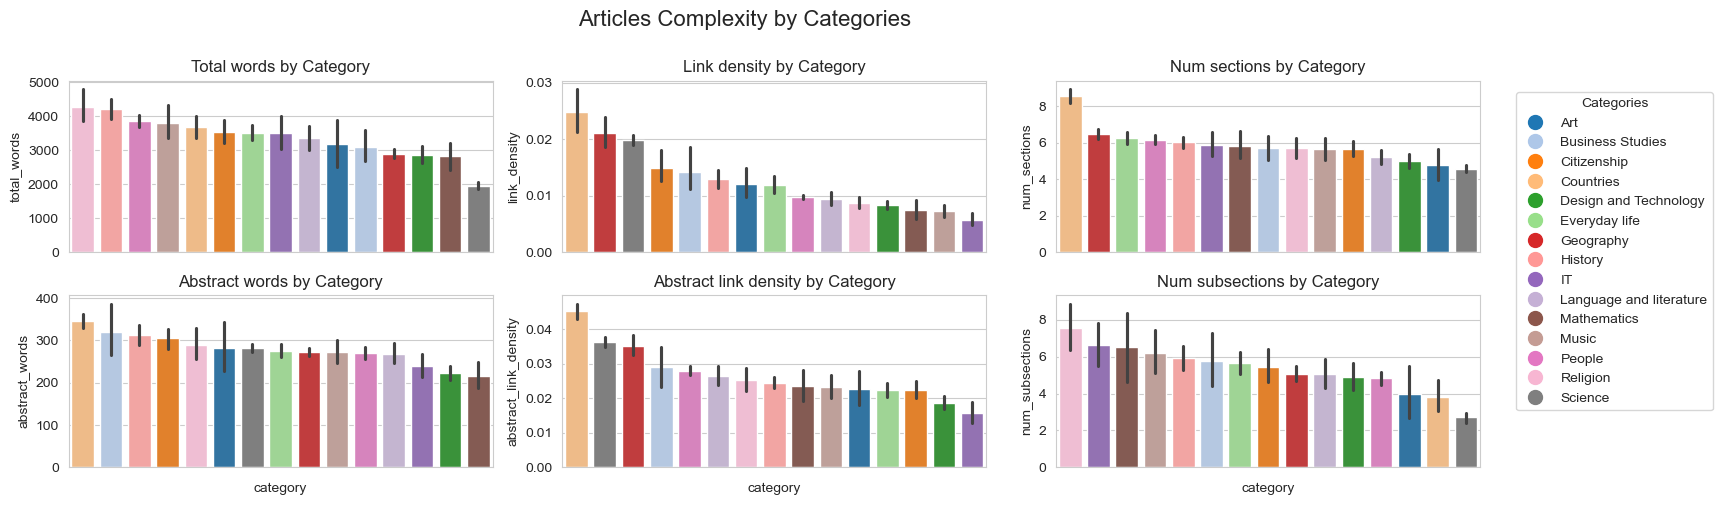

In [292]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Define the parameters for each subplot
metrics = [
    "total_words", "link_density", "num_sections",
    "abstract_words", "abstract_link_density", "num_subsections"
]

# Loop through metrics and plot
for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    order = df_html_stats.groupby("category")[metric].mean().sort_values(ascending=False).reset_index()["category"]
    sn.barplot(
        x="category", 
        y=metric, 
        hue="category", 
        palette=color_mapping, 
        data=df_html_stats, 
        ax=ax[row, col], 
        order=order
    )
    ax[row, col].legend_.remove() 
    ax[row, col].set_title(f'{metric.replace("_", " ").capitalize()} by Category')
    ax[row, col].set_xticklabels([])
    if row == 0 :
        ax[row, col].set_xlabel('')

add_legend_category(fig)

plt.suptitle("Articles Complexity by Categories", y=1, fontsize=16)
plt.tight_layout()
plt.show()

Results : The category "Countries" stands out as a particularly complex topic, characterized by articles with the highest link density, the greatest number of category levels, and the longest abstract.

### 3.1.c Articles Popularity and Connectivity

Is there a correlation between the number of links in an article and the frequency with which people interact with it in the game? Does this depend more on the in-degree or out-degree of the links? And is there a significant difference between the in-degree and out-degree of links? We will compare and investigate these factors to understand their impact on article interaction.

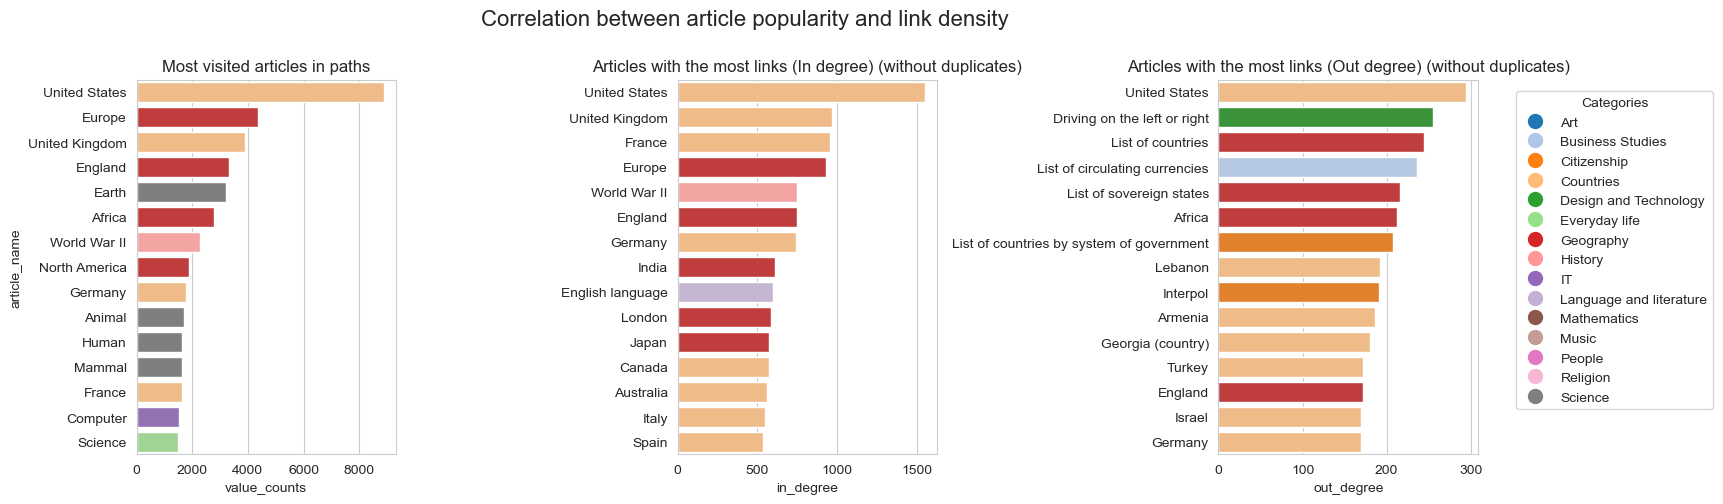

In [293]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

#Plot the most visited articles in finished paths
all_articles = []
df_finished['path'].apply(lambda x: all_articles.extend(x.split(';')))
df_path_articles = pd.Series(all_articles).value_counts().rename_axis('article_name').reset_index(name='value_counts')
df_path_articles["category"]=df_path_articles["article_name"].apply(lambda x: df_categories[df_categories["article"]==x]["level_1"].values[0] if len(df_categories[df_categories["article"]==x]["category"].values)>0 else "None")
df_path_articles = df_path_articles[df_path_articles['article_name'] != '<']

sn.barplot(x='value_counts', y='article_name', hue="category", palette=color_mapping, data=df_path_articles.head(15), ax=ax[0])
ax[0].set_title('Most visited articles in paths')
ax[0].legend_.remove() 

for i, metric in enumerate(["in_degree", "out_degree"]):
    sn.barplot(x=metric, y='article', hue="category", palette=color_mapping, data=df_article.sort_values(metric, ascending=False).head(15), ax=ax[i+1])
    ax[i+1].set_title(f'Articles with the most links ({metric.replace("_", " ").capitalize()}) (without duplicates)')
    ax[i+1].legend_.remove()
    ax[i+1].set_ylabel('')

add_legend_category(fig)
plt.suptitle("Correlation between article popularity and link density", y=1, fontsize=16)
plt.tight_layout()

Results : We observe a significant overlap between the most visited articles and those with the highest degree. Additionally, the "Countries" category is prominently represented.

### 3.1.d Articles structure : html Parsing

In [294]:
df_html_articles = parser.article_names # The html articles in the data
df_article_names = read_articles() # The articles used in the paths-and-graph data
intersect = pd.merge(df_html_articles, df_article_names, how='inner', on="article")
print(f'There are {len(df_article_names)} articles in the paths-and-graph data and {len(intersect)} of those are in the html articles.')
difference = df_html_articles[~df_html_articles.isin(df_article_names)]
print(f'This means there are {len(difference)} articles more in the html data, such as "{difference.iloc[0]}", "{difference.iloc[5]}" or "{difference.iloc[10]}".')

There are 4597 articles in the paths-and-graph data and 4597 of those are in the html articles.
This means there are 635 articles more in the html data, such as "2006 Autumn Newsletter Focus On Bethlehem", "About Child Sponsorship" or "Aids Africa".


In [295]:
parsed = parser.parse_html_article(parser.article_URLs[266])
if parsed: parser.get_overview(parsed)

In [296]:
import ipywidgets as widgets
from IPython.display import display

sort_column = widgets.Dropdown(
    options=df_html_stats.columns,
    value='total_words',
    description='Sort by:'
)

n_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description='Number (n):'
)

# Display function to update table based on widget values
def display_sorted(n, sort_by):
    sorted_df = df_html_stats.sort_values(by=sort_by, ascending=False)
    top_n = sorted_df.head(n)
    bottom_n = sorted_df.tail(n)
    
    print(f"\nTop {n} Articles by {sort_by}:")
    display(top_n)
    print(f"\nBottom {n} Articles by {sort_by}:")
    display(bottom_n)

# Link widgets to display function
widgets.interactive(display_sorted, n=n_slider, sort_by=sort_column)


interactive(children=(IntSlider(value=5, description='Number (n):', max=20, min=1), Dropdown(description='Sort…

## 3.2. Analyse user behaviour

Let's look for patterns in user behaviour and try to understand how we could measure whether a game was difficult or not. Many different metrics can be considered, for instance:
- Game duration
- Game path length
- Difficulty rating given for finished paths
- Number of back-clicks needed
- Whether a game was finished or not
- For unfinished games, how the game was abandoned

A combination of these parameters can help finding in which games users struggled. This will then allow to assess whether players struggle less in <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than in other paths.

Let's first have a look of how the difficulty measures are distributed amongst each other for finished paths.

### 3.2.1. Path duration and path length vs. user rating

Let's first look at path duration distribution for different user rating.

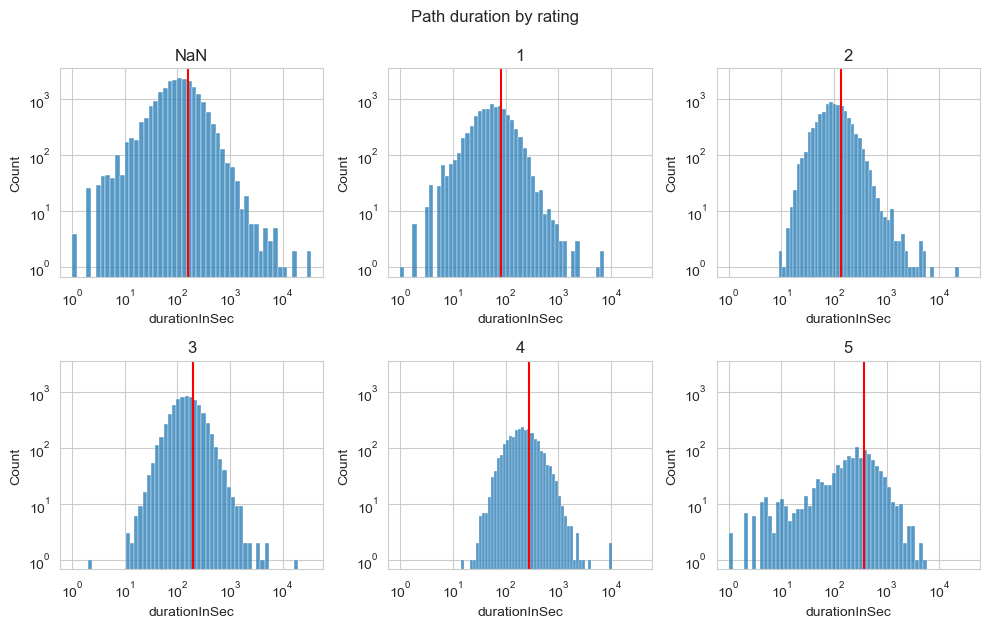

In [297]:
df_finished_strNaN = df_finished.copy()
df_finished_strNaN['rating'] = df_finished_strNaN['rating'].fillna('NaN')

plt.figure(figsize=(10, 6))

means, stds = [], []
ax1 = plt.subplot(231)
sn.histplot(df_finished[df_finished_strNaN['rating']=='NaN'], x='durationInSec', bins=50, log_scale=True) # change x to x = 'path_length' for path length
plt.axvline(df_finished[df_finished_strNaN['rating']=='NaN']['durationInSec'].mean(), color='red')
plt.yscale('log')
plt.title('NaN')

for i in range(1, 6):
    plt.subplot(231+i, sharex = ax1, sharey=ax1)
    sn.histplot(df_finished[df_finished_strNaN['rating']==i], x='durationInSec', bins=50, log_scale=True)
    plt.axvline(df_finished[df_finished_strNaN['rating']==i]['durationInSec'].mean(), color='red')
    plt.yscale('log')
    plt.title(i)

plt.tight_layout()
plt.suptitle('Path duration by rating', y=1.04)
plt.show()

The distributions of the path duration by rating are nice log-normal distributions! This means we can use the mean (location) and standard deviation (scale) to characterise them. Indeed, except for NaN, there is a steady increase of the path duration mean when rating goes up.

Let's now look at whether path duration is correlated with path length in terms of number of clicks:

In [298]:
df_path_stats_duration = pd.DataFrame()
df_path_stats_duration['mean'] = df_finished.groupby('rating', dropna=False)['durationInSec'].mean()
df_path_stats_duration['std'] = df_finished.groupby('rating', dropna=False)['durationInSec'].std()
df_path_stats_duration['sem'] = df_finished.groupby('rating', dropna=False)['durationInSec'].sem()

df_path_stats_length = pd.DataFrame()
df_path_stats_length['mean'] = df_finished.groupby('rating', dropna=False)['path_length'].mean()
df_path_stats_length['std'] = df_finished.groupby('rating', dropna=False)['path_length'].std()
df_path_stats_length['sem'] = df_finished.groupby('rating', dropna=False)['path_length'].sem()

df_path_stats = pd.concat([df_path_stats_duration, df_path_stats_length], axis=1, keys=['duration', 'length'])

df_path_stats

duration                            length                     
              mean         std        sem       mean        std       sem
rating                                                                   
1.0      80.150609  152.273618   1.648539   4.664909   2.052327  0.022219
2.0     137.036683  311.602204   3.325851   5.996355   2.432872  0.025967
3.0     195.863962  296.518511   3.482914   7.640866   3.706646  0.043538
4.0     281.351095  359.639492   6.870559  10.079927   5.871245  0.112164
5.0     368.231304  463.405289  13.665076  13.237391  17.200507  0.507215
NaN     158.130412  430.645883   2.855092   6.818030   4.030492  0.026721

<Axes: xlabel='rating', ylabel='path_length'>

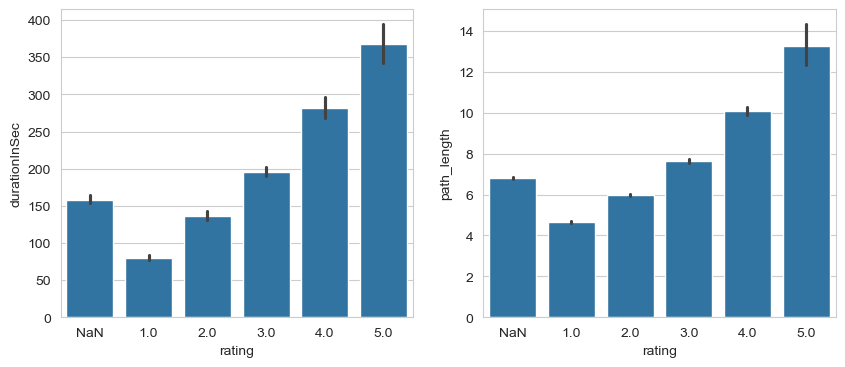

In [299]:
order = ['NaN', '1.0', '2.0', '3.0', '4.0', '5.0']

plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.barplot(df_finished_strNaN, x='rating', y='durationInSec', order=order, errorbar=('ci', 95))
plt.subplot(122)
sn.barplot(df_finished_strNaN, x='rating', y='path_length', order=order, errorbar=('ci', 95))

There is a clear correlation between how long players took or how many clicks they made with the experienced difficulty rating. This means we can easily combine the two into a difficulty measure as they agree with each other on what players considered difficult. 

Let's now consider unfinished paths: can we find other clues that indicate whether players had a hard time?

The mean duration of finished paths is 158 seconds
The mean duration of unfinished paths is 835 seconds


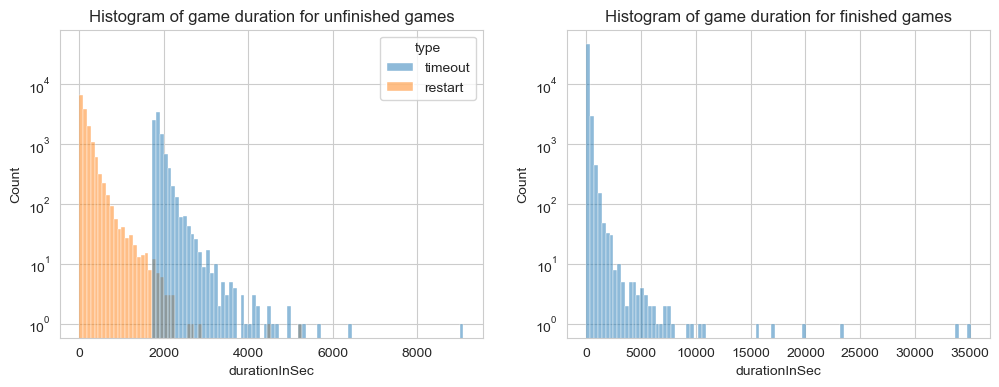

In [300]:
# find means for both timeout and restart

print(f"The mean duration of finished paths is {df_finished['durationInSec'].mean():.0f} seconds")
print(f"The mean duration of unfinished paths is {df_unfinished['durationInSec'].mean():.0f} seconds")

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
sn.histplot(df_unfinished, x='durationInSec', hue='type', bins=100)
plt.yscale('log')
plt.title('Histogram of game duration for unfinished games')

plt.subplot(122, sharey = ax1)
sn.histplot(df_finished, x='durationInSec', bins=100, alpha=0.5)
plt.yscale('log')
plt.title('Histogram of game duration for finished games')
plt.show()

The number of back clicks made in a game can also be a measure of players getting stuck. What is the distribution of back clicks and do they correlate with other metrics?

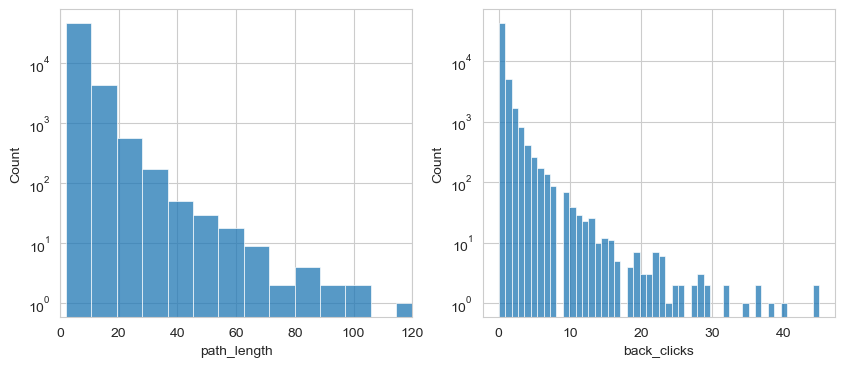

In [301]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.histplot(df_finished, x='path_length', bins=50)
plt.yscale('log')
plt.xlim(0, 120)

plt.subplot(122)
sn.histplot(df_finished, x='back_clicks', bins=50)
plt.yscale('log')

### backclics :Correlation between the rating, the backclip number and the topics
Here we explore to which extend the backclicks might be correlated with difficulty and topics. 

In [302]:
df_categories_filtered = filter_most_specific_category(df_categories)
paths_finished = extract_category_path(df_finished, df_categories_filtered)
paths_finished = backtrack(paths_finished)

C:\Users\david\AppData\Local\Temp\ipykernel_19620\586097747.py:5: UserWarning:

The palette list has more values (6) than needed (5), which may not be intended.



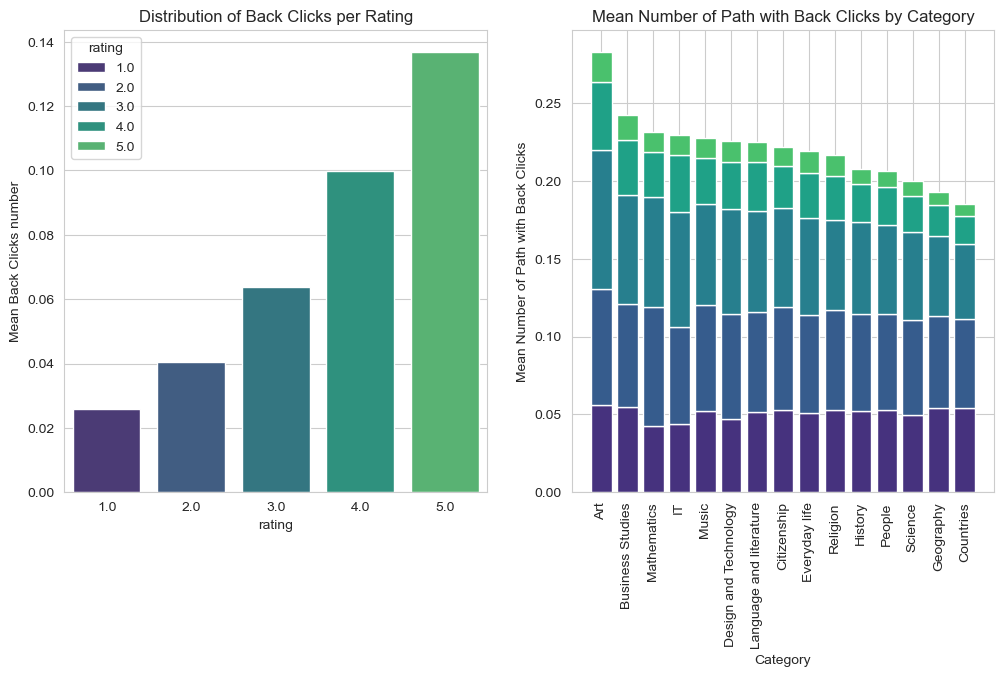

In [303]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

back_per_rating = paths_finished.groupby("rating").agg({"back_nb": "mean", "size": "mean"}).reset_index()
back_per_rating['Mean Back Clicks number'] = back_per_rating["back_nb"]/back_per_rating["size"]
sn.barplot(x="rating", y='Mean Back Clicks number', hue="rating", data=back_per_rating, palette=sn.color_palette('viridis'), ax=ax[0])

df_exploded = paths_finished.explode('category')
category_back_mean = df_exploded.groupby(['category', 'rating']).size().reset_index(name='size')
back_mean = df_exploded.groupby('category')["have_back"].mean().reset_index().sort_values(by='have_back', ascending=False)
category_back_mean = category_back_mean.merge(back_mean, on='category').sort_values(by='have_back', ascending=False)
category_back_mean['rating_proportion'] = category_back_mean.groupby('category')['size'].transform(lambda x: x / x.sum())

order = category_back_mean["category"].unique()
base_heights = category_back_mean[['category', 'have_back']].drop_duplicates().set_index('category')['have_back']
df_pivot = category_back_mean.pivot(index='category', columns='rating', values='rating_proportion').fillna(0)
df_pivot = df_pivot.reindex(order)

colors = sn.color_palette('viridis')

bottom = pd.Series([0] * len(df_pivot), index=df_pivot.index)
for i, rating in enumerate(df_pivot.columns):
    ax[1].bar(df_pivot.index, 
           height=df_pivot[rating] * base_heights,  
           bottom=bottom * base_heights,           
           label=f'Rating {rating}', 
           color=colors[i])
    bottom += df_pivot[rating]

ax[1].set_title('Mean Number of Path with Back Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Mean Number of Path with Back Clicks')
plt.xticks(rotation=90)
ax[0].set_title("Distribution of Back Clicks per Rating")
plt.show()

The backclicks are correlated with the difficulty rating, which is expected as the more difficult a game is, the more likely players are to get stuck and go back.
The category with the most backclicks is "Art", and the one with the least is "Countries". This is interesting as "Countries" is also one of the most visited category, which might indicate that players are more familiar with it and therefore less likely to get stuck.
Additionaly, The distribution of rating inside each category seams quite similar.

## 3.3 Look at articles as a categories types

### A. Categories Distributions

In [304]:
import plotly.graph_objects as go

labels, parents, values, ids = create_treemap_data(df_categories)
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
    textfont=dict(size=18),
))
fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles: some articles have multiple categories ( > Number of articles)")
fig.show()

In [305]:
print("We have",df_categories["level_1"].unique().size, "distinct level 1 categories.")

We have 15 distinct level 1 categories.


- Each category is organized into multiple sub-levels, with a hierarchical depth of up to 3 levels.

- For this analysis, we will focus exclusively on the most superficial level: Level 1.

- Additionally, we observe that some articles are associated with multiple categories, highlighting overlaps and shared connections within the dataset.

#### Articles with Multiples Categories

- First we count the numbers of articles with multiples categories:

In [306]:
# Count the number of articles with multiples categories
df_categories.groupby("article")["article"].size().value_counts()

article
1    3999
2     590
3       8
Name: count, dtype: int64

- But if we constraint only to different type of level 1 categories, it is reduced to :

In [307]:
# Count the number of unique level 1 categories per article
df_categories.groupby("article")["level_1"].nunique().value_counts()

level_1
1    4091
2     505
3       1
Name: count, dtype: int64

In [308]:
category_abbreviations = {
    'Art': 'Art',
    'Mathematics': 'Math',
    'IT': 'IT',
    'Business Studies': 'BS',
    'Music': 'Music',
    'Religion': 'R',
    'Language and literature': 'L&L',
    'Citizenship': 'CIT',
    'Countries': 'C',
    'Design and Technology': 'D&T',
    'Everyday life': 'Life',
    'History': 'Hist',
    'People': 'P',
    'Geography': 'Geo',
    'Science': 'Sci'
}

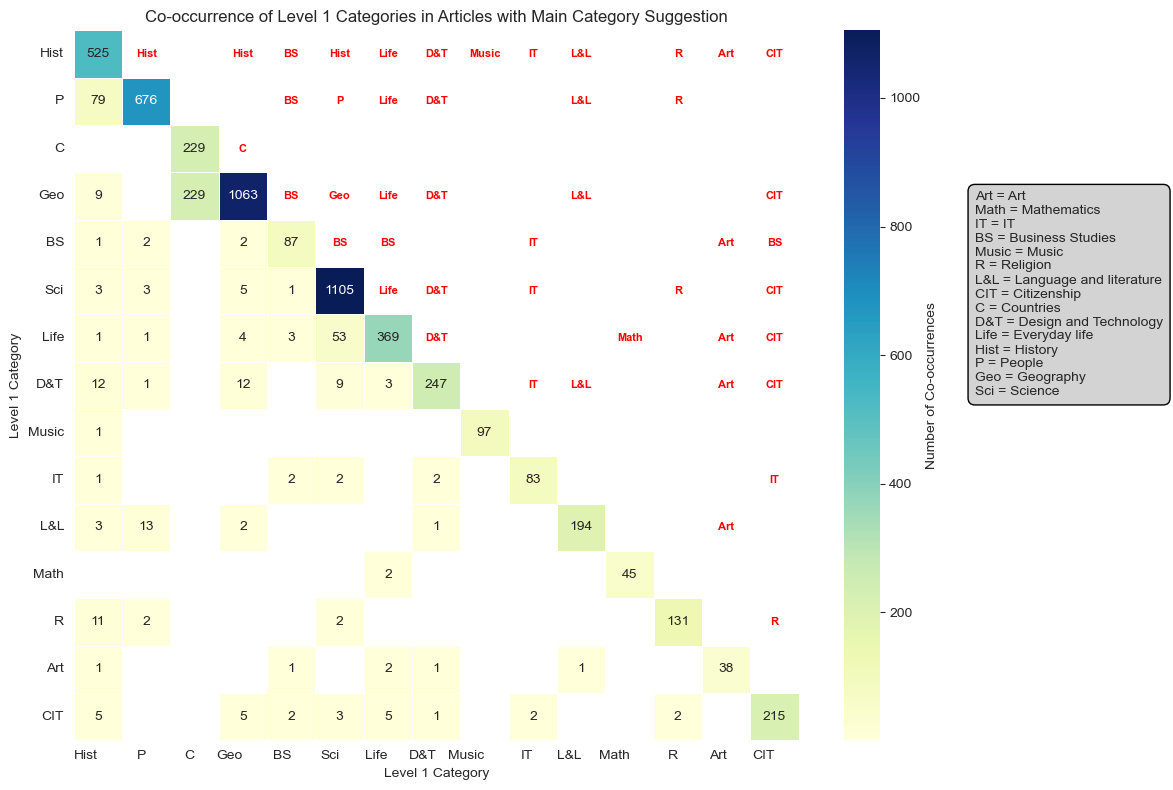

In [346]:
plot_cooccurrence_cat_matrix(df_categories, category_abbreviations)

Attributing the **main category** to articles with multiple categories based on the category **with fewer total articles** helps prioritize specialization over generality. 

Categories with fewer total articles are typically more specific, while those with higher counts cover broader topics. By focusing on the category with fewer articles, we ensure the article’s primary focus is on a unique or specialized perspective, providing a clearer thematic assignment. This method promotes a balanced classification system, ensuring articles are categorized accurately without being overshadowed by more general categories.

- For example, a category like **"Geography"** may encompass a wide range of topics, while **"Countries"** might be more specialized.

In [310]:
df_categories_filtered = filter_most_specific_category(df_categories)

labels_filtered, parents_filtered, values_filtered, ids_filtered = create_treemap_data(df_categories_filtered)
fig = go.Figure(go.Treemap(
    labels=labels_filtered,
    parents=parents_filtered,
    values=values_filtered,
    ids=ids_filtered,
    textfont=dict(size=18),
))

fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles (Only the most specific category is shown for each article)")
fig.show()

### B. Transitions between categories

We decide to merge the paths finished and unfinished as in this section we will first only analyse how users make moves between categories of articles, independ of their succes on the research.

In [311]:
paths_merged = pd.concat([df_finished, df_unfinished])
common_paths = analyze_categories_paths(paths_merged, df_categories_filtered, omit_loops=False)

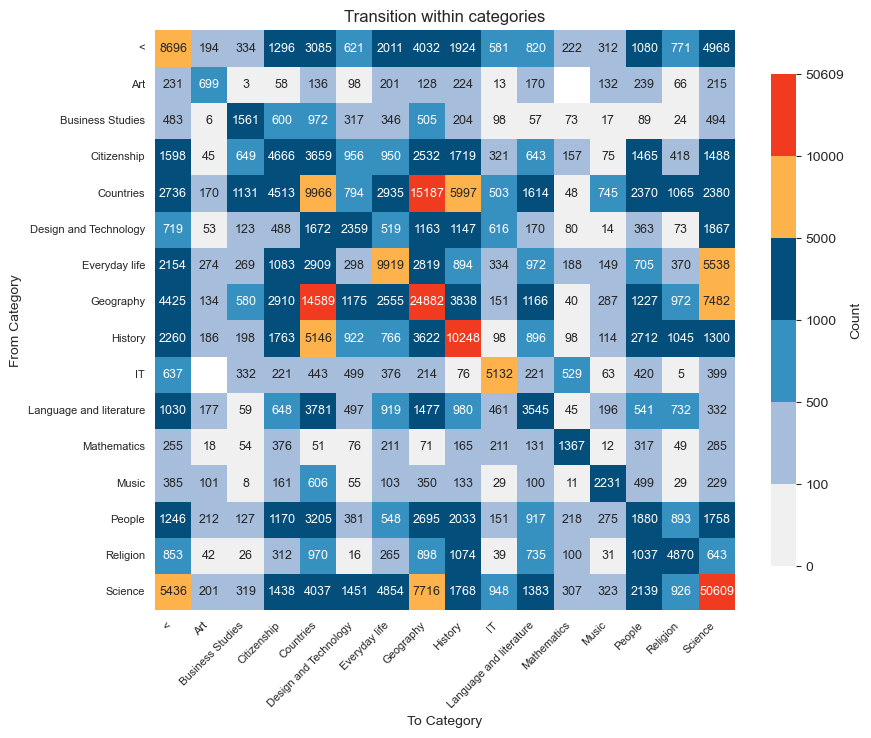

In [347]:
matrix_f = matrix_common_paths(common_paths)
transition_cat_matrix(matrix_f)

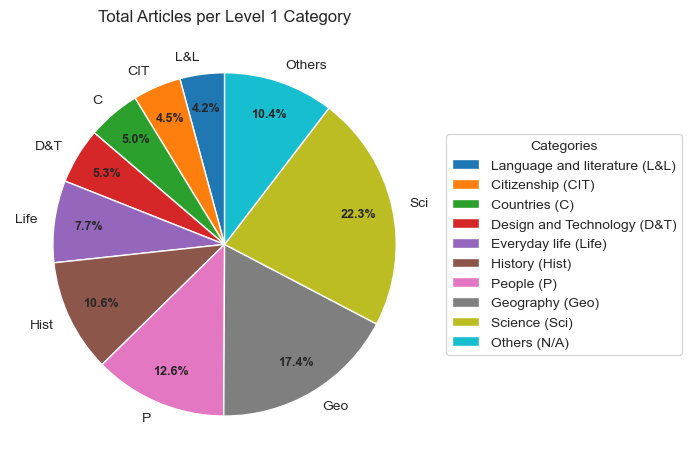

In [313]:
plot_articles_pie_chart(df_categories_filtered, category_abbreviations)

#### Transitions within categories (included self-category)

Example :
- Science -> Science -> Science
- Science -> Science -> Science -> Citizenship -> Design and Technology

In [314]:
df_position_data = get_position_frequencies(common_paths, max_position=15)
plot_position_line(df_position_data, title="Position Frequencies for Finished Paths")

#### Transitions within categories (excluded self-category)

Example :
- Science -> Science -> Science **become** Science
- Science -> Science -> Science -> Citizenship -> Design and Technology **become** Science -> Citizenship -> Design and Technology

In [315]:
common_paths_nl = analyze_categories_paths(paths_merged, df_categories_filtered, omit_loops=True)

In [316]:
df_position_data = get_position_frequencies(common_paths_nl, max_position=15)
plot_position_line(df_position_data, title="Position Frequencies for Finished Paths")

### C. Networks

In [317]:
paths_merged_with_replace_back = paths_merged['path'].apply(replace_back_clicks)

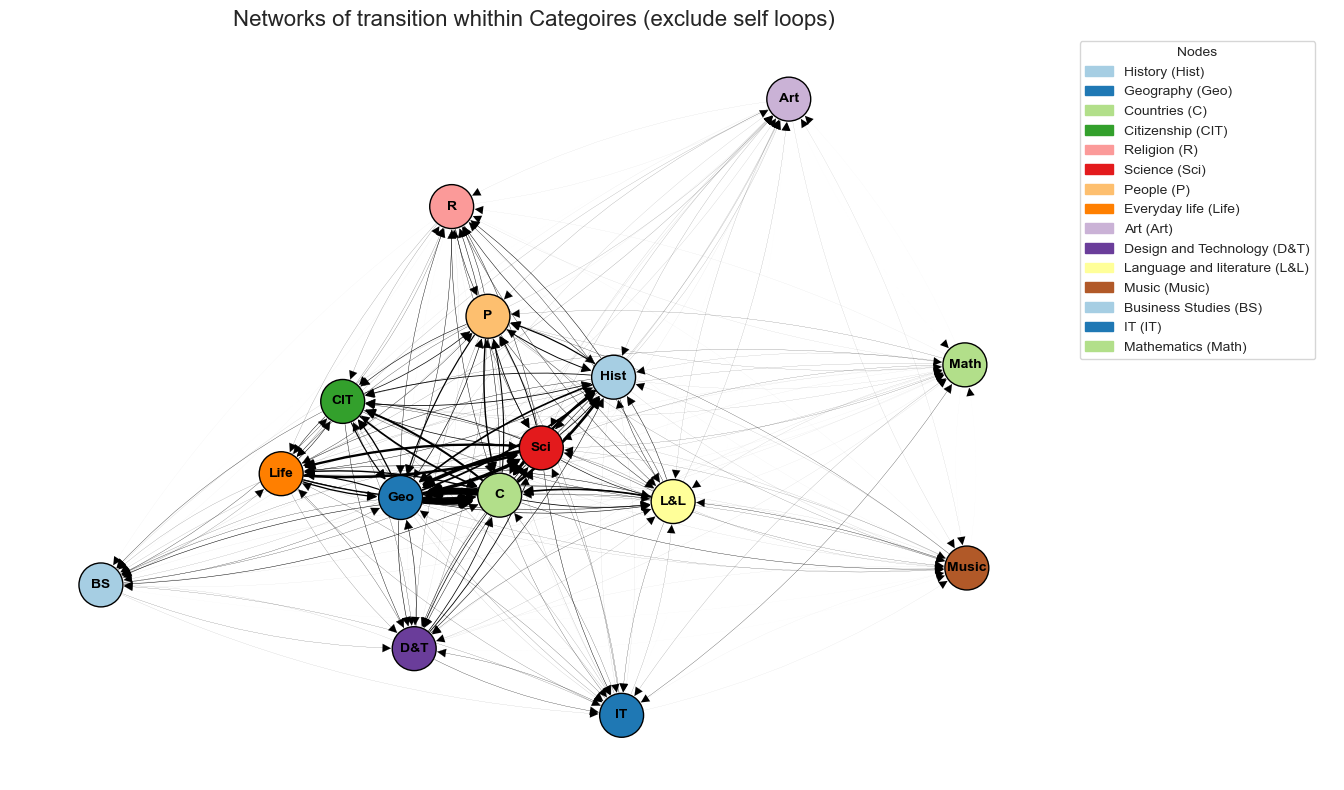

In [318]:
G = build_network(paths_merged_with_replace_back, df_categories_filtered, include_self_loops=False)

plot_network(G, title="Networks of transition whithin Categoires (exclude self loops)", show_edge_labels=False, node_size=1000, node_abbreviations=category_abbreviations)

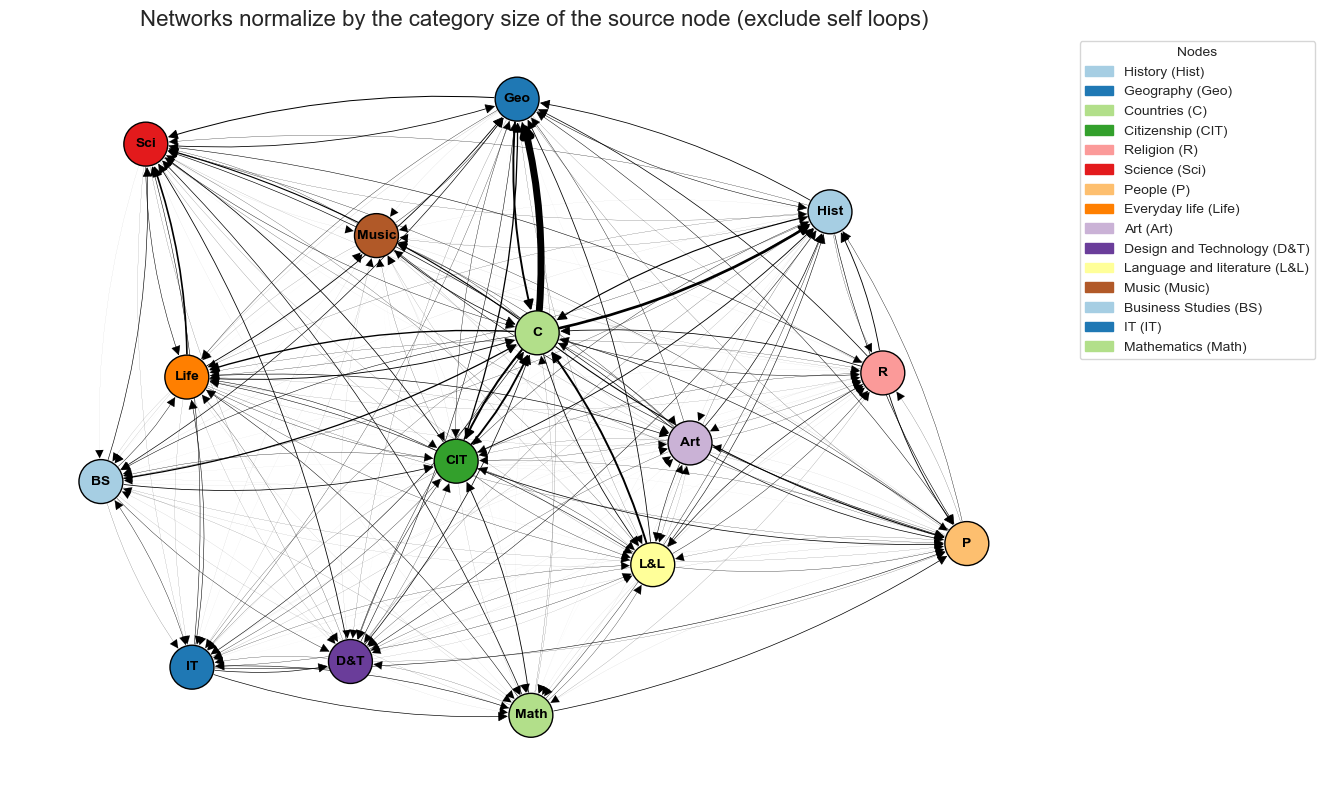

In [319]:
G_normalized = normalize_edge_weights(G, df_categories_filtered)
plot_network(G_normalized, title="Networks normalize by the category size of the source node (exclude self loops)", show_edge_labels=False, node_size=1000, node_abbreviations=category_abbreviations)

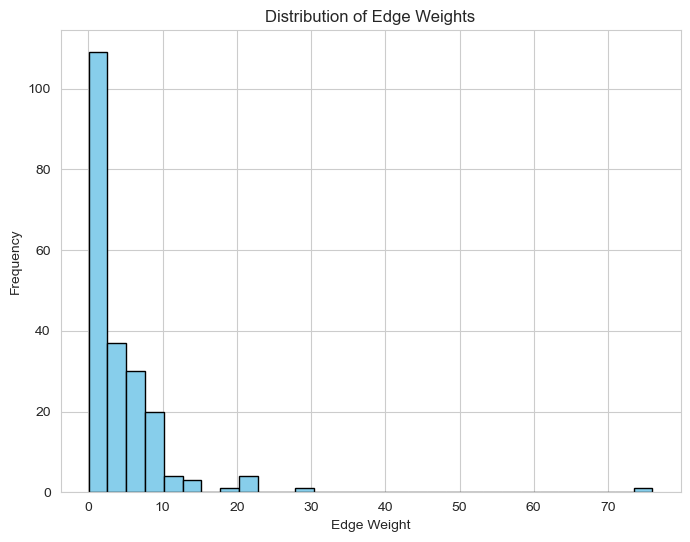

,Edge Weight Statistics
Count,210.000000
Mean,4.275123
Median,2.431531
Standard Deviation,6.708277
Min,0.036145
Max,75.982533
25th Percentile,0.820169
75th Percentile,5.722344


In [320]:
analyze_edge_weights(G_normalized)

### Start And Target Categories in finished and unfinished paths

🚨 ici ce serait pas mieux de mettre les counts en pourcentage? 🚨

In [321]:
paths_finished = find_categories_start_end(df_finished, df_categories)
paths_unfinished = find_categories_start_end(df_unfinished, df_categories)

paths_finished["finished"] = 1
paths_unfinished["finished"] = 0

paths = pd.concat([paths_finished, paths_unfinished], join='inner')
paths_melted = paths.melt(
    id_vars=["finished"],
    value_vars=["start_category", "end_category"],
    var_name="category_type",
    value_name="category"
)

c:\Users\david\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight

C:\Users\david\AppData\Local\Temp\ipykernel_19620\2371908340.py:29: UserWarning:

The figure layout has changed to tight



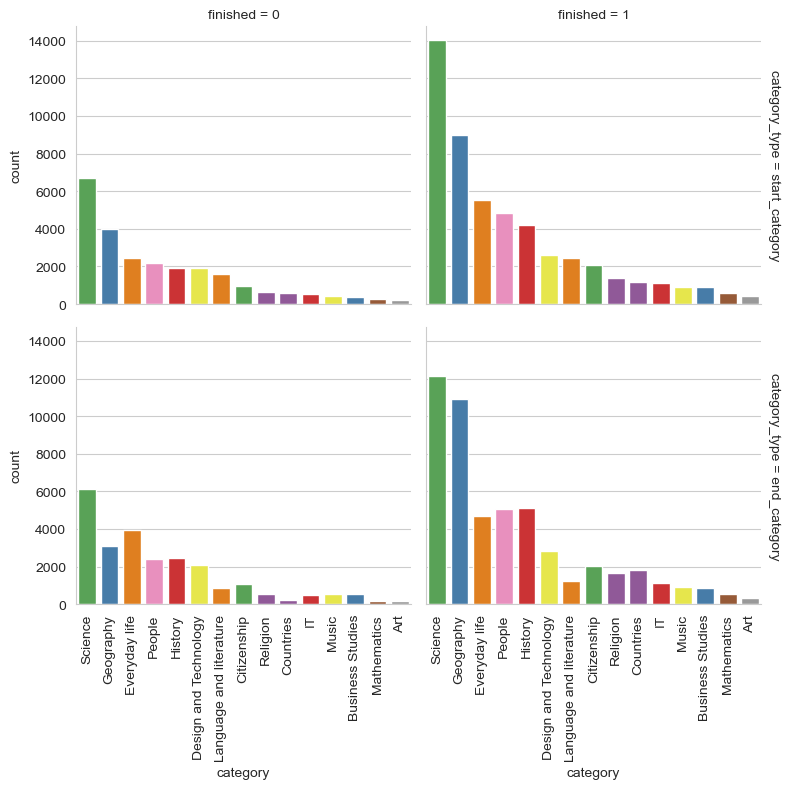

In [322]:
# Create a color palette based on unique categories
unique_categories = paths_melted['category'].unique()
palette = sn.color_palette("Set1", n_colors=len(unique_categories))
color_mapping = dict(zip(unique_categories, palette))

g = sn.FacetGrid(
    data=paths_melted,
    col="finished",
    row="category_type",
    sharey=True,
    sharex=True,
    margin_titles=True,
    height=4,
)

g.map_dataframe(
    sn.countplot,
    x="category",
    hue="category",
    palette=color_mapping,
    order=paths_melted['category'].value_counts().index  # Order by frequency
)

# Rotate x-axis labels for readability
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

ANALYSIS

## 3.4 Correlations and combination between previous results

### A. Corelation between difficulty and combination of source-target categories

Let's get a glance at the extend to which the choice of the source article and the end article affects the difficulty of the game.
This could highlight potential combinations of categories that are harder to connect.

Different difficulty metrics are used like path duration, path length in terms of number of clicks and user ratings. 

The number of backclicks and its link with current difficulty mettrics and categories is also studied to explore whether it indicates difficulty as well.
#### Correlation between the duration of game and the combination of source-target category
Here the difficulty measure is the game duration. 

🚨put different colors for finished ans unfinished, so the colorbar isnt the same for diffrent scales🚨

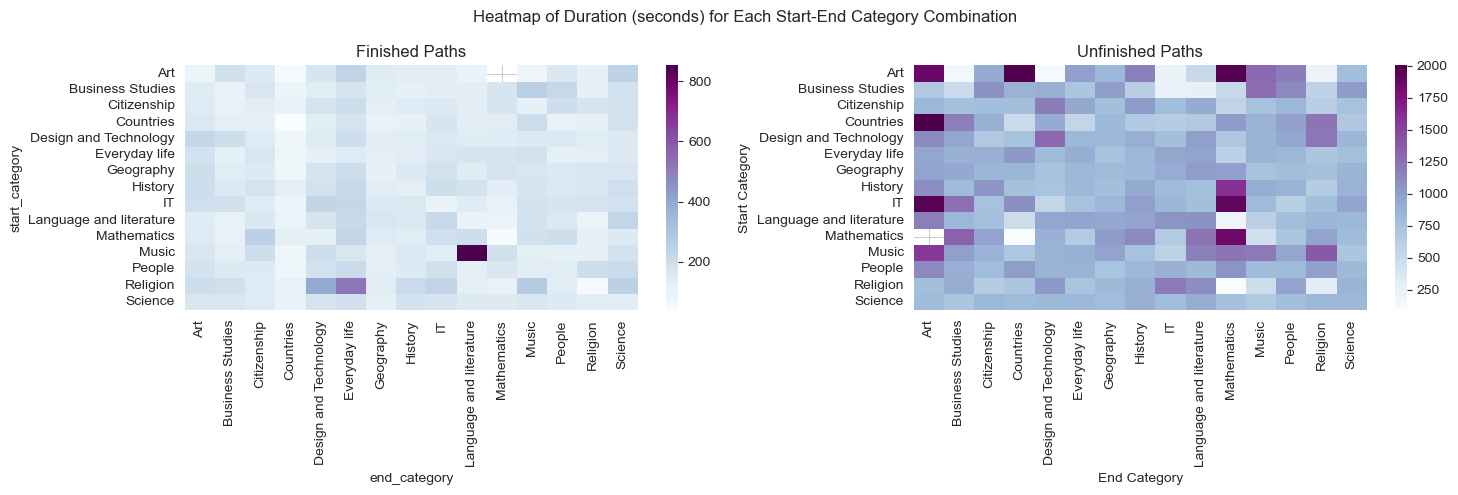

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='durationInSec', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='durationInSec',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sn.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of Duration (seconds) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

Linking a music article to a language and litterature article is the combination that takes the longest time (≈800s) to connect in finished paths. In unfinished paths, it takes ≈1300s, maybe indicating players tend to abandon due to difficulty? 

Curiously, connnecting art to mathematics is either very fast (<100s) in succesfull games, or takes a very long time (≈2000s) in unsuccesfull ones, this is also observed in connecting mathematics to mathematics for example.

In the other hand, connecting religion to religion takes a short time both in succesfull and unsuccesfull games. A short finished path might indicate easily connectable categories, whereas short unfinished paths could indicate early abandonment. Why would easilly conectable source and target lead to early abandonment for other players? Maybe this scenario can divide into two : either the target is directly on the source page or just a few clicks away, either they are not so close (for example linked to different religions), the density of links in the page might be low and the player might lack knowledge in the field. These potential causes will be analize in further parts.

#### Correlation between the length of path and the combination of source-target category
Here the difficulty metric used is the number of clicks in the game. 

🚨put different colors for finished ans unfinished, so the colorbar isnt the same for diffrent scales🚨

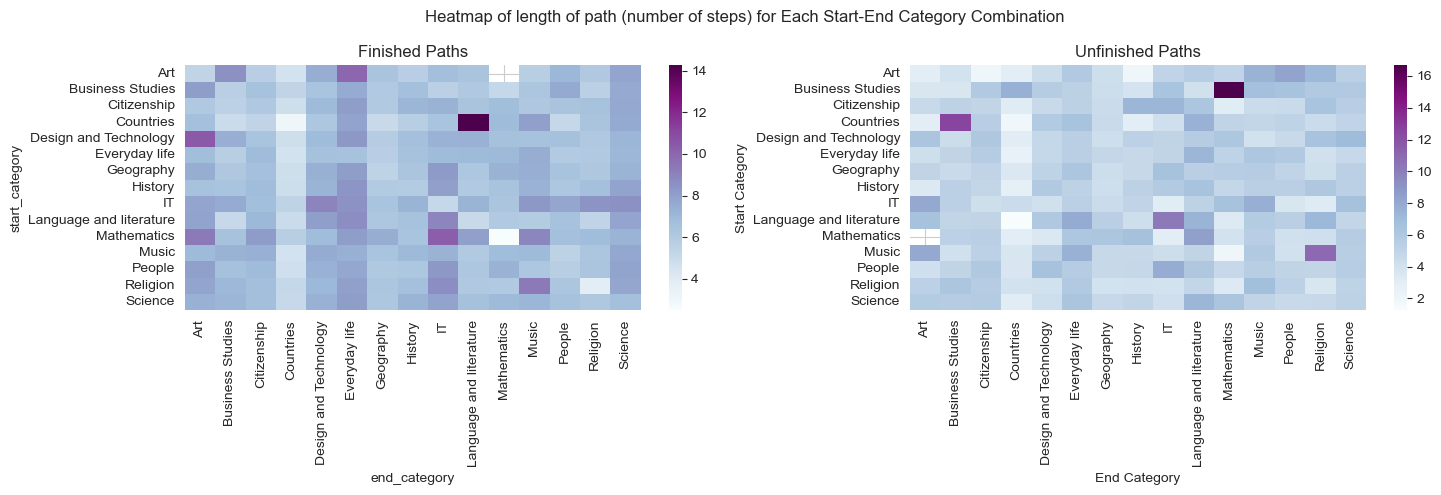

In [324]:
paths_finished["steps_count"] = paths_finished["path"].apply(lambda x: len(x.split(";")))
paths_unfinished["steps_count"] = paths_unfinished["path"].apply(lambda x: len(x.split(";")))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='steps_count', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='steps_count',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sn.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of length of path (number of steps) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

#### Correlation between the player rating and the combination of source-target category
Here we use the difficulty rating by the players as difficulty metric.

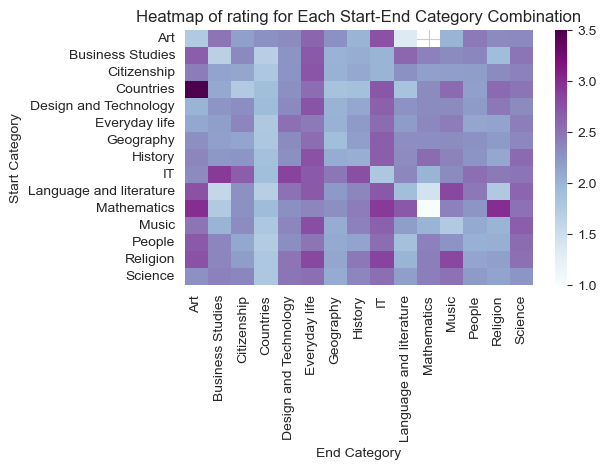

In [325]:
path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='rating', 
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu')
plt.title("Heatmap of rating for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

# 4. Methods proof of concept
## a. Similarity on paths

#### Correlation between source-target similarity, and shortest possible path length
Similar articles should be easier to connect, let's verify this using shortest possible path length as a difficulty measure.

We will look at article's semantic symilarity using cossine similarity, and article's category similarity. Pearson and Spearman correlations will then be used to asses how significant these difficulty measures are.

In [326]:
df_finished

,hashedIpAddress,timestamp,durationInSec,path,rating,cosine_similarity,shortest_path,path_length,back_clicks,categories_similarity,...,category,back_nb,size,have_back,start,end,start_category,end_category,finished,steps_count
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th century;15th century;16th century;Pacific...,NaN,0.353137,3,9,0,1.0,...,"[Geography, History]",0,9,False,14th century,African slave trade,History,History,1,9
1,3824310e536af032,2012-08-12 06:36:52,88,14th century;Europe;Africa;Atlantic slave trad...,3.0,0.353137,3,5,0,1.0,...,"[Geography, History]",0,5,False,14th century,African slave trade,History,History,1,5
2,415612e93584d30e,2012-10-03 21:10:40,138,14th century;Niger;Nigeria;British Empire;Slav...,NaN,0.353137,3,8,0,1.0,...,"[Citizenship, Geography, Countries, History]",0,8,False,14th century,African slave trade,History,History,1,8
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th century;Renaissance;Ancient Greece;Greece,NaN,0.371986,2,4,0,0.0,...,"[Countries, History]",0,4,False,14th century,Greece,History,Countries,1,4
4,015245d773376aab,2013-04-23 15:27:08,175,14th century;Italy;Roman Catholic Church;HIV;R...,3.0,0.331395,3,7,0,0.0,...,"[Countries, History, Citizenship, Religion, Pe...",0,7,False,14th century,John F. Kennedy,History,People,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51194,15a13a1d66ef5456,2012-10-03 02:23:35,66,Yagan;Ancient Egypt;Civilization,NaN,0.390763,2,3,0,0.0,...,"[Citizenship, People, History]",0,3,False,Yagan,Civilization,People,Citizenship,1,3
51195,2ef7ac844cefda58,2011-03-16 05:42:18,165,Yagan;Folklore;Brothers Grimm;<;19th century;C...,3.0,0.346304,3,9,1,0.0,...,"[Religion, Language and literature, People, Hi...",1,9,True,Yagan,Fiction,People,Language and literature,1,9
51196,12863abb7887f890,2013-11-22 04:42:52,228,Yagan;Australia;England;France;United States;T...,NaN,0.269246,3,7,0,0.0,...,"[Geography, Everyday life, People, Countries]",0,7,False,Yagan,U.S. Open (tennis),People,Everyday life,1,7
51197,19f8284371753362,2011-02-27 07:42:47,56,"Yarralumla, Australian Capital Territory;Austr...",1.0,0.271264,2,4,0,0.0,...,"[Countries, People, Geography]",0,4,False,"Yarralumla, Australian Capital Territory",Abraham Lincoln,Geography,People,1,4


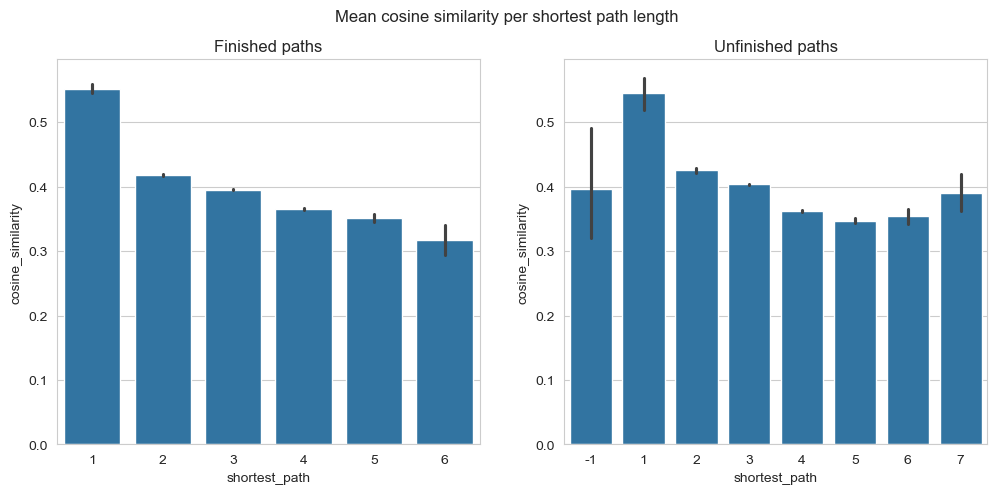

In [327]:
# note: -1 with no errorbar makes no sense. 1 with no error bar makes sense (trivial case where start=target and similarity with itself=1)

df_finished_clean = df_finished[df_finished['shortest_path'] != 0].copy()

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished_clean, x='shortest_path', y='cosine_similarity')
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='cosine_similarity')
plt.title('Unfinished paths')

plt.suptitle('Mean cosine similarity per shortest path length')
plt.show()

In [328]:
from scipy.stats import pearsonr, spearmanr

def calculate_correlations_with_shortestPath(df, column_name):
    # Ensure 'shortest_path' is numeric
    df['shortest_path'] = df['shortest_path'].astype(float)

    pearson_corr, pearson_p = pearsonr(df['shortest_path'], df[column_name])
    spearman_corr, spearman_p = spearmanr(df['shortest_path'], df[column_name])

    # Print results
    print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")
    print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4e}")

print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished_clean,"cosine_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"cosine_similarity")

Finished paths:
Pearson correlation: -0.2837, p-value: 0.0000e+00
Spearman correlation: -0.2359, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.2732, p-value: 0.0000e+00
Spearman correlation: -0.2751, p-value: 0.0000e+00


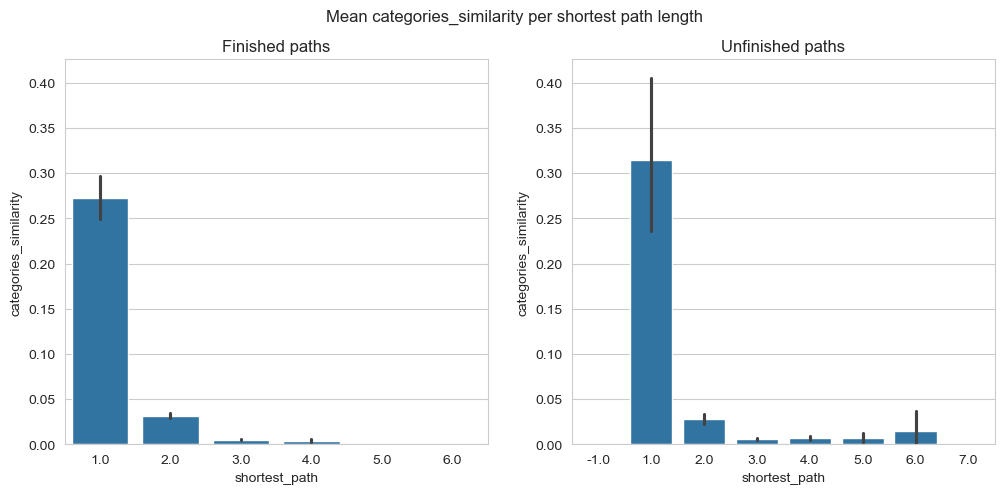

In [329]:
# note: -1 with no errorbar makes no sense. 1 with no error bar makes sense (trivial case where start=target and similarity with itself=1)
# impossible paths in unfinishes paths are possible however. check if it is sound though because of the previous problem.

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished_clean, x='shortest_path', y='categories_similarity')
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='categories_similarity')
plt.title('Unfinished paths')

plt.suptitle('Mean categories_similarity per shortest path length')
plt.show()

In [330]:
print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished_clean,"categories_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"categories_similarity")

Finished paths:
Pearson correlation: -0.1968, p-value: 0.0000e+00
Spearman correlation: -0.1938, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.0763, p-value: 3.3577e-33
Spearman correlation: -0.0816, p-value: 8.2011e-38


The **Pearson correlation** measures the linear relationship between two continuous variables. And the **Spearman correlation** assesses the monotonic relationship using ranked data, making it less sensitive to outliers and non-linear relationships.


The article semantic similarity, and category similarity of finished paths have **moderate negative correlation** with path length (≈-0.25), and the category similarity of unfinished paths has weak negative correlation (≈-0.2).

Both for articles and category similarity, the **p-values are zero**, showing high statistical significance. The observed correlations are thus unlikely to be due to random chance.

Negative correlation indicates that as the minimal possible path length increases, the cosine_similarity decreases.
In other words, when the source and targets articles are close semantically, and their categories similar, the shortest possible path shrinkens, which makes sense as is it easier to connect 2 very similar articles. The correlations are however moderate to weak, indicating that even if this true in general, closely related source and target are not sufficient to explain this form of difficulty. We therefore aim to find other difficulty measures.

### Semantic Similarity
An interesting way to figure out how players move through the wikispeedia network is semantic similarity. This encompasses both categories similarity and the abstract notion of "meaning". To concretise this notion, we consider two different measures of similarity:

Find clusters of words that are more similar to each other than to words in other clusters. The clustering allows to reorder the similarity matrix in a way that regroups articles with high similarity.

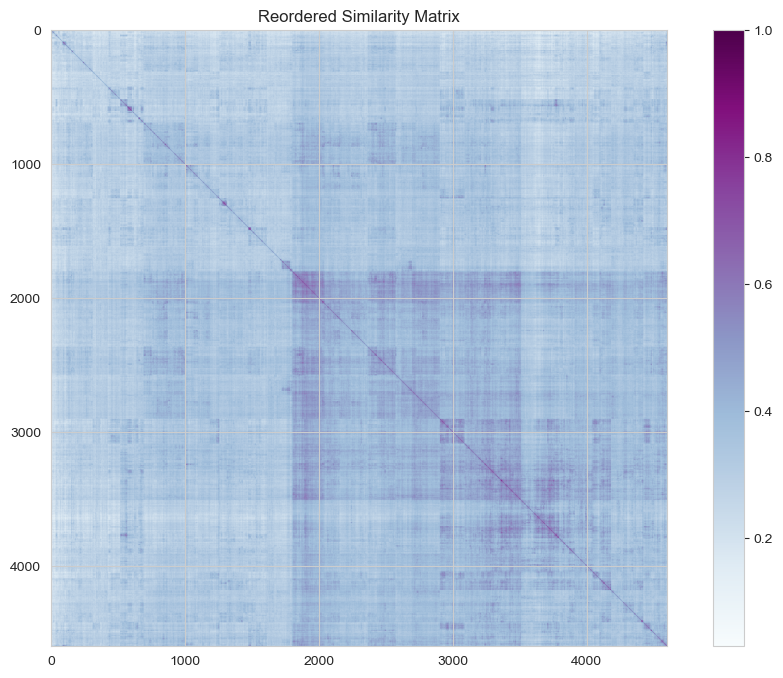

In [331]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

# Perform hierarchical clustering
sm = df_sm.to_numpy()
linkage_matrix = linkage(sm, method='ward')
ordered_indices = leaves_list(linkage_matrix)
reordered_matrix = sm[ordered_indices, :][:, ordered_indices]

plt.figure(figsize=(12, 8))
plt.imshow(reordered_matrix, cmap='BuPu')
plt.title('Reordered Similarity Matrix')
plt.colorbar()
plt.show()

In [332]:
import ipywidgets as widgets
from IPython.display import display

# Define the initial threshold
initial_threshold = 0.5

# Function to plot the binary matrix based on a given threshold
def plot_thresholded_matrix(threshold):
    # Create a binary mask with the current threshold
    binary_matrix = np.where(reordered_matrix >= threshold, 1, 0)
    
    # Plot the binary matrix
    plt.figure(figsize=(12, 8))
    plt.imshow(binary_matrix, cmap='Reds', interpolation='nearest')
    plt.title(f'Reordered Similarity Matrix (Threshold = {threshold:.2f})')
    plt.colorbar(label='Above Threshold (1 = Red, 0 = White)')
    plt.show()

# Create the interactive slider
threshold_slider = widgets.FloatSlider(
    value=initial_threshold,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Threshold:',
    continuous_update=False
)

# Display the slider and link it to the plotting function
output = widgets.interactive_output(plot_thresholded_matrix, {'threshold': threshold_slider})
display(threshold_slider, output)

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0, step=0.01)

Output()

In [333]:
upper_triangle_indices = np.triu_indices_from(sm, k=1) # Flatten the upper triangle of the matrix without the diagonal for sorting

# Get the sorted indices for most similar pairs (descending order)
sorted_similar_indices = np.argsort(-sm[upper_triangle_indices])
top_similar_pairs = list(zip(upper_triangle_indices[0][sorted_similar_indices], 
                             upper_triangle_indices[1][sorted_similar_indices]))

print("Top 5 most similar pairs:")
for i, (idx1, idx2) in enumerate(top_similar_pairs[:5]):
    print(f"Pair {i+1}: Articles '{df_article_names[idx1]}' and '{df_article_names[idx2]}' with similarity {sm[idx1, idx2]:.4f}")

sorted_dissimilar_indices = np.argsort(sm[upper_triangle_indices])
top_dissimilar_pairs = list(zip(upper_triangle_indices[0][sorted_dissimilar_indices], 
                                upper_triangle_indices[1][sorted_dissimilar_indices]))

# Print the top 5 most dissimilar pairs
print("\nTop 5 most dissimilar pairs:")
for i, (idx1, idx2) in enumerate(top_dissimilar_pairs[:5]):
    print(f"Pair {i+1}: Articles '{df_article_names[idx1]}' and '{df_article_names[idx2]}' with similarity {sm[idx1, idx2]:.4f}")

Top 5 most similar pairs:
Pair 1: Articles 'Polish–Muscovite War (1605–1618)' and 'Polish-Muscovite War (1605–1618)' with similarity 0.9983
Pair 2: Articles 'Democratic Republic of the Congo' and 'Republic of the Congo' with similarity 0.9681
Pair 3: Articles 'George H. W. Bush' and 'George W. Bush' with similarity 0.9658
Pair 4: Articles 'Canadian Senate' and 'Senate of Canada' with similarity 0.9625
Pair 5: Articles 'Gliese 876' and 'Gliese 876 d' with similarity 0.9453

Top 5 most dissimilar pairs:
Pair 1: Articles 'Augustan literature' and 'Keira Knightley' with similarity 0.0301
Pair 2: Articles 'List of Test cricket triple centuries' and 'Venezuela' with similarity 0.0363
Pair 3: Articles 'List of Test cricket triple centuries' and 'São Paulo' with similarity 0.0373
Pair 4: Articles 'Brasília' and 'List of Test cricket triple centuries' with similarity 0.0399
Pair 5: Articles 'Cuba' and 'List of Test cricket triple centuries' with similarity 0.0433


In [334]:
print('The reordered article indices make intuitive sense, similar words are regrouped')
print(df_article_names[ordered_indices].iloc[1995:2005])
print(df_article_names[ordered_indices].iloc[450:460])

The reordered article indices make intuitive sense, similar words are regrouped
2029             Humour
2532              Logic
3410              Radio
3411    Radio frequency
3408              Radar
3438           Recorder
1130              Dance
3433            Rapping
3420               Rain
3797              Sound
Name: article, dtype: object
63            A. E. J. Collins
1269            E. E. Cummings
2208           James D. Watson
2186             J. J. Thomson
2188           J. M. W. Turner
1270              E. P. Wigner
2276    John Seigenthaler, Sr.
2213             James K. Polk
4495           William N. Page
4386              W. Mark Felt
Name: article, dtype: object


### Evolution of similarity on paths
find similarity on geo vs non-geo paths

In [335]:
all_finished_paths = [replace_back_clicks(path).split(';') for path in df_finished['path'].tolist()]
path_similarities = []

for path in all_finished_paths:
    path_similarity = []
    for step in range(len(path)-1):
        current, next = path[step], path[step+1]
        path_similarity.append(df_sm[current][next])

    path_similarities.append(path_similarity)

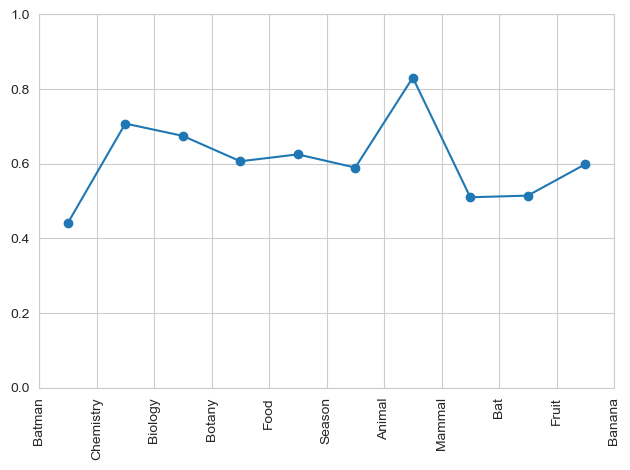

In [336]:
path_id = 1829
path = path_similarities[path_id]
plt.plot(range(len(path)), path, marker='o')
plt.xticks([i-0.5 for i in range(len(path)+1)], all_finished_paths[path_id], rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [337]:
len_N_path_similarity = {}
for path_sim in path_similarities:
    path_length = len(path_sim)
    len_N_path_similarity.setdefault(path_length, []).append(path_sim)

len_N_mean_similarity = {paths_len: np.mean(paths, axis=0) for paths_len, paths in len_N_path_similarity.items()}

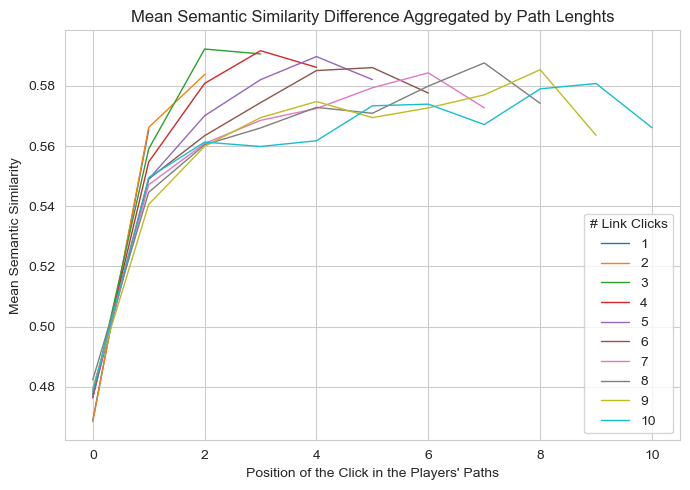

In [338]:
plt.figure(figsize=(7, 5))
for i in range(1, 11):
    sn.lineplot(len_N_mean_similarity[i+1], lw=1, label=i)
plt.legend(title='# Link Clicks')
plt.xlabel("Position of the Click in the Players' Paths")
plt.ylabel('Mean Semantic Similarity')
plt.title('Mean Semantic Similarity Difference Aggregated by Path Lenghts')
plt.tight_layout()
plt.show()

# 5. Find Voyages
### Sort games into voyage or not-voyage 

In [339]:
df_finished_voyage = game_voyage_sorting(df_finished, df_categories, True, n=3)
df_unfinished_voyage = game_voyage_sorting(df_unfinished, df_categories, False, n=3)

voyage_count = (df_finished_voyage['voyage'] == 1).sum() + (df_unfinished_voyage['voyage'] == 1).sum()
non_voyage_count = (df_finished_voyage['voyage'] == 0).sum() + (df_unfinished_voyage['voyage'] == 0).sum()
print('out of', len(df_finished_voyage)+len(df_unfinished_voyage), 'games : ')
print('  - ', voyage_count, ' are voyages')
print('  - ', non_voyage_count, ' are not')

out of 75913 games : 
  -  37956  are voyages
  -  37957  are not


In [340]:
import pandas as pd
import plotly.graph_objects as go

# Mapping for start, voyage, and end nodes
df_finished_voyage['start_category_label'] = df_finished_voyage['start_category'].apply(lambda x: 'First in Countries/Geography' if x in ['Countries', 'Geography'] else 'First not in Countries/Geography')
df_finished_voyage['end_category_label'] = df_finished_voyage['end_category'].apply(lambda x: 'Target in Countries/Geography' if x in ['Countries', 'Geography'] else 'Target not in Countries/Geography')
df_finished_voyage['voyage_label'] = df_finished_voyage['voyage'].apply(lambda x: 'Voyage' if x else 'Non-Voyage')

# Count occurrences for each flow from start -> voyage -> end
flows = df_finished_voyage.groupby(['start_category_label', 'voyage_label', 'end_category_label']).size().reset_index(name='count')

# Define nodes for the Sankey diagram
labels = ['First in Countries/Geography', 'First not in Countries/Geography',
          'Voyage', 'Non-Voyage',
          'Target in Countries/Geography', 'Target not in Countries/Geography']

# Create mappings for source and target node indices
label_map = {label: i for i, label in enumerate(labels)}

# Map flows to Sankey source, target, and value arrays
sources = []
targets = []
values = []

for _, row in flows.iterrows():
    # Add start -> voyage
    sources.append(label_map[row['start_category_label']])
    targets.append(label_map[row['voyage_label']])
    values.append(row['count'])

    # Add voyage -> end
    sources.append(label_map[row['voyage_label']])
    targets.append(label_map[row['end_category_label']])
    values.append(row['count'])


node_colors = [
    "rgba(0, 128, 128, 0.6)",  "rgba(244,109,67,0.8)",   
    "rgba(0, 128, 128, 0.6)",  "rgba(244,109,67,0.8)",   
    "rgba(0, 128, 128, 0.6)",  "rgba(244,109,67,0.8)"
    ]

link_colors = [
    "rgba(146,197,222,0.6)",  "rgba(244,109,67,0.6)",   
    "rgba(146,197,222,0.6)",  "rgba(244,109,67,0.6)",   
    "rgba(146,197,222,0.6)",  "rgba(244,109,67,0.6)"
    ]

# Create the Sankey plot
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="white", width=0.1), label=labels, color=node_colors),
    link=dict(source=sources, target=targets, value=values)
)])

#######WHERE DOES THIS GO ????
fig.update_layout(
    title_text="Path classification as Voyage or not",
    font_size=10,
    title_font_size=14,
    title_x=0.5,
    plot_bgcolor="white"
)

fig.show()


# 6. Analyse voyages
### ➜ This is our milestone P3!


In [341]:
shortest_path_matrix = read_shortest_path_matrix()

Total pairs: 21132409
Reachable pairs: 18579594
Unreachable pairs: 2548218
Sparsity percentage: 12.08%
Total pairs: 21132409
Reachable pairs: 18579594
Unreachable pairs: 2548218
Sparsity percentage: 12.08%


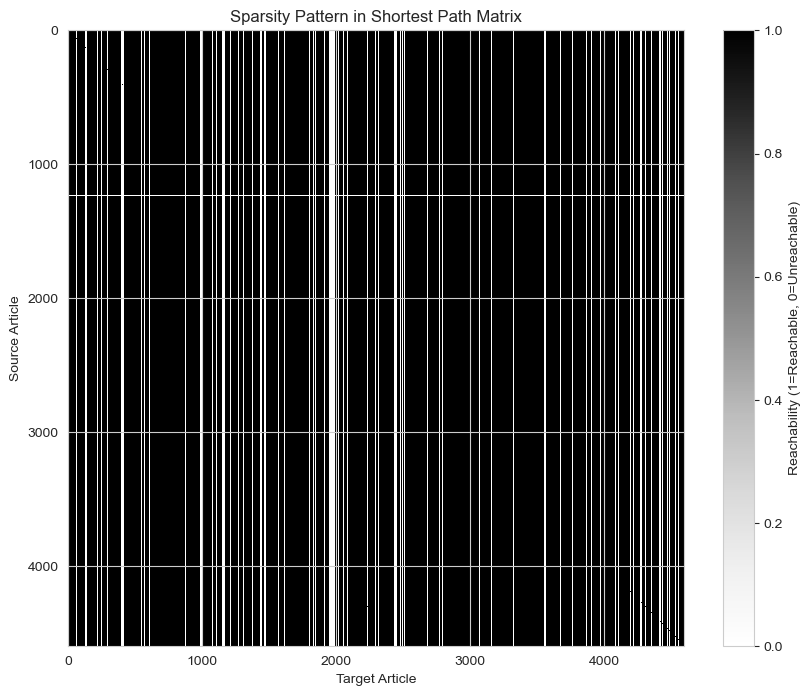

In [342]:
# Total number of article pairs
total_pairs = shortest_path_matrix.size

# Number of reachable pairs (distance from 1 to 9)
# Exclude self-pairs where distance is 0
# Unreachable pairs are represented by -1

# Create a mask for self-pairs (distance == 0)
self_pairs_mask = (shortest_path_matrix == 0)

# Create a mask for reachable pairs (distance between 1 and 9)
reachable_mask = (shortest_path_matrix >= 1) & (shortest_path_matrix <= 9)


reachable_pairs = np.count_nonzero(reachable_mask)
unreachable_pairs = np.count_nonzero(shortest_path_matrix == -1)

# Sparsity percentage: proportion of unreachable pairs
sparsity_percentage = ((unreachable_pairs + len(self_pairs_mask) ) / total_pairs) * 100

print(f"Total pairs: {total_pairs}")
print(f"Reachable pairs: {reachable_pairs}")
print(f"Unreachable pairs: {unreachable_pairs}")
print(f"Sparsity percentage: {sparsity_percentage:.2f}%")

# Total number of article pairs
total_pairs = shortest_path_matrix.size

# Number of reachable pairs (distance from 1 to 9)
# Exclude self-pairs where distance is 0
# Unreachable pairs are represented by -1

# Create a mask for self-pairs (distance == 0)
self_pairs_mask = (shortest_path_matrix == 0)

# Create a mask for reachable pairs (distance between 1 and 9)
reachable_mask = (shortest_path_matrix >= 1) & (shortest_path_matrix <= 9)


reachable_pairs = np.count_nonzero(reachable_mask)
unreachable_pairs = np.count_nonzero(shortest_path_matrix == -1)

# Sparsity percentage: proportion of unreachable pairs
sparsity_percentage = ((unreachable_pairs + len(self_pairs_mask) ) / total_pairs) * 100

print(f"Total pairs: {total_pairs}")
print(f"Reachable pairs: {reachable_pairs}")
print(f"Unreachable pairs: {unreachable_pairs}")
print(f"Sparsity percentage: {sparsity_percentage:.2f}%")

# Create a binary matrix where 1 represents a reachable path and 0 represents an unreachable path
sparsity_matrix = np.where(shortest_path_matrix == -1, 0, 1)

plt.figure(figsize=(10, 8))
plt.imshow(sparsity_matrix, cmap='Greys', interpolation='nearest')
plt.title('Sparsity Pattern in Shortest Path Matrix')
plt.xlabel('Target Article')
plt.ylabel('Source Article')
plt.colorbar(label='Reachability (1=Reachable, 0=Unreachable)')
plt.show()

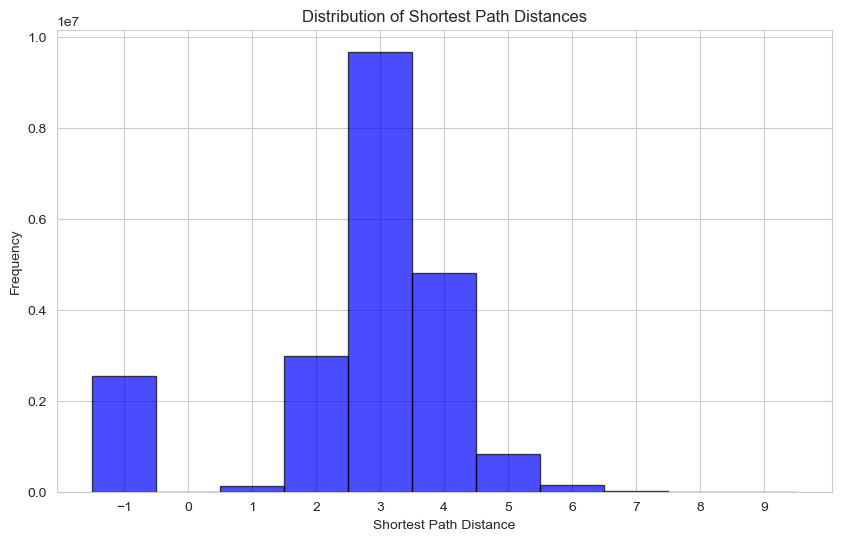

In [343]:
plt.figure(figsize=(10, 6))
plt.hist(shortest_path_matrix.values.flatten(), bins=np.arange(-1,11,1) - 0.5 , color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Shortest Path Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path Distances')
plt.xticks(np.arange(-1,10,1))
plt.show()